# **Homework 2 - Semantic Segmentation**
## Lívia Cereja Meinhardt

O objetivo deste *homework 2* é implementar uma rede U-net para *semantic segmentation*, uma técnica de visão computacional que classifica cada pixel de uma imagem como pertencente a uma classe distinta. Desta forma, é uma técnica com aplicações diversas como: detecção de anomalias médias, carros autônomos, distinção de objetos, etc.

Neste exercícios, utilizamos uma base de dados contento imagens de satélite, disponível em: [https://drive.google.com/file/d/1TU2nTVGS2932hRs1u-ma4r3vmgqHRbMO/view?usp=sharing]. O objetivo, então, é implementar uma rede U-net capaz de distinguir entre superfícies, prédios, vegetação baixa, árvores e carros, como exemplificado nas imagens abaixo:

<figure>
<center>
<img src= 'https://raw.githubusercontent.com/mabelortega/DL_Semantic_Segmentation/main/Figures/drawing1.png'/>
</figure>

# **Importando pacotes necessários**

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from osgeo import ogr, gdal
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from keras import backend as K

# added libs
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model 
import os
from google.colab import drive
from math import ceil
import plotly.graph_objects as go


# **Carregando as imagens**

Primeiramente iremos carregar as imagens usando a função *load_tiff_image* e, em seguida, normaliza-las no range [0,1] usando a função *normalization*. Ambas estão definidas abaixo:



In [2]:
def load_tiff_image(image):
  print (image)
  gdal_header = gdal.Open(image)
  img = gdal_header.ReadAsArray()
  return img

def normalization(image):
  image_reshaped = image.reshape((image.shape[0]*image.shape[1]),image.shape[2])
  scaler = MinMaxScaler(feature_range=(0,1))
  scaler = scaler.fit(image_reshaped)
  image_normalized_ = scaler.fit_transform(image_reshaped)
  image_normalized = image_normalized_.reshape(image.shape[0],image.shape[1],image.shape[2])
  return image_normalized

# Etapa 1
#acessa o drive e 'abre' o diretório em que estão as imagens
drive.mount('/content/drive')
os.chdir("drive/My Drive/Lab_files/")

# baixando as imagens
#precisando transpor as imagens para o 'shape' ser válido
tr_img = normalization(load_tiff_image("Image_Train.tif")).T
tr_ref_img =  normalization(load_tiff_image("Reference_Train.tif")).T
test_img = normalization(load_tiff_image("Image_Test.tif")).T
test_ref_img = normalization(load_tiff_image("Reference_Test.tif")).T

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Image_Train.tif
Reference_Train.tif
Image_Test.tif
Reference_Test.tif


# **Dividir as imagens em patches**

Agora, dividiremos as imagens carregadas em patches - cortes das imagens originais - de forma a aumenta nosso conjunto de dado. 

Para isso, foi implementada a função *extract_patches*, que utiliza o método do keras de mesmo nome para realizar esse processo. Foi necessário aumentar em uma dimensão o conjunto de dados 3D original, uma vez que o método do keras requer um array 4D. Por fim, a função auxiliar *extract_patches* retorna os dados no *shape* (#images, #patche_size, #patche_size, #channels).

Um exemplo do resultado é demostrado ao final do processo:

In [3]:
def reshape_patches(data,patch_size,channels):
  new_shape = data.shape[1]*data.shape[2]
  return tf.reshape(data,(new_shape,patch_size,patch_size,channels))


def extract_patches(image, reference, patch_size, stride,skip_resize=False):

  reference = tf.expand_dims(reference, 0) #input da funcao tem que ser 4D
  image = tf.expand_dims(image, 0)

  ref_paches = tf.image.extract_patches(images=reference,
                           sizes=[1, patch_size, patch_size, 1],
                           strides=[1, stride, stride, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')
  
  img_paches = tf.image.extract_patches(images=image,
                           sizes=[1, patch_size, patch_size, 1],
                           strides=[1, stride, stride, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')
  
  if not skip_resize:
    img_paches = reshape_patches(img_paches,patch_size,channels) #reshape  
    ref_paches = reshape_patches(ref_paches,patch_size,channels)
  
  return img_paches, ref_paches

<Figure size 432x288 with 0 Axes>

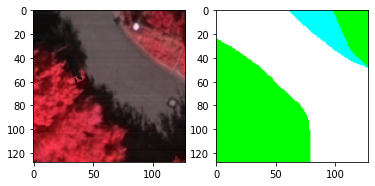

In [4]:
# Etapa 2 
patch_size = 128
stride = 128 # valores baixos esgotam a memoria
channels = 3
n_classes = 5

patches_train, patches_train_ref = extract_patches(tr_img, tr_ref_img, patch_size, stride)

# mostra exemplo
plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(patches_train[1])
axarr[1].imshow(patches_train_ref[1])

# **Dividir o conjunto de treino e validação aleatóriamente**

Em seguida precisamos dividir o conjunto de treino em duas partes: treino e validação. Além dissom, iremos aleatorizar a order dos patches. 

Para isso, foi implementada a função *split_patches*, que recebe a imagem, a referência e o tamanho do conjunto de validação e retorna quadro conjuntos de dados: treino, referencia do treino, validação e referencia da validacao.

Por fim, é mostrado o patche da imagem e referência com o mesmo índice do exemplo anterior - para mostrar o efeito do shuffe. 

In [5]:
# split the tensor data 
def split_patches(data, reference, val_size):

    # tamanho do dataset 
    size_val = ceil(data.shape[0]*val_size)
    size_train = data.shape[0] - size_val

    # aplica o shuffe no índice das imagens
    # de forma que a referencia e a imagem continuem correspondentes 
    indices = tf.range(start=0, limit=data.shape[0], dtype=tf.int32)
    shuffled_indices = tf.random.shuffle(indices)

    # aplica o shuffe
    shuffled_data = tf.gather(data, shuffled_indices)
    shuffled_referecence = tf.gather(reference, shuffled_indices)

    #divisão dos dados de teino e validacao
    train, valuation= tf.split(shuffled_data, (size_train,size_val), axis=0)
    ref_train, ref_val =  tf.split(shuffled_referecence, (size_train,size_val), axis=0)

    return train, valuation, ref_train, ref_val 


<Figure size 432x288 with 0 Axes>

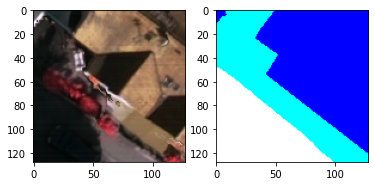

In [6]:
#Etapa 3
patches_train, patches_valuation, patches_train_ref, patches_valuation_ref = split_patches(patches_train,patches_train_ref, 0.2)

# show that dataset is shuffled

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(patches_train[1])
axarr[1].imshow(patches_train_ref[1])

# **One hot encoding**

Agora convertemos a referência usando a técnica do *one-hot-encoding*

Não é possível utilizar o método do keras diretamente, é necessário um pré-processamento nas matrizes. Primeiro convertemos os patches para uma escala de cinza - diminuindo os canais de cores (que eram três para um), logo removemos a dimensão desnecessária. Em seguida, para evitar problemas numéricos, multiplicamos por 100 e arredondamos os valores da escala de cinza. Por fim, mapeamos cada valor único resultante para um número de 0 a 4 (já que temos 5 classes). 

Com essa transformação é possível aplicar o método do keras.

A imagem abaixo exemplifica o processo, demostrando a versão original e as cinco imagens finais resultantes:

In [7]:
def one_hot_encoding(patches):

    grey_ = tf.image.rgb_to_grayscale(patches) #converter para escala de cinza 

    # RGB tem 3 canais de cor; escala de cinza só precisa de 1
    # squeeze remove a dimensão desncessária (valor 1)
    new_patches = tf.squeeze(grey_) 
    new_patches = np.round(new_patches*100) # muultiplico por 100 para evitar classificacao incorreta
    patches_unique = np.unique(new_patches) 

    # Tentei usar esse método: https://stackoverflow.com/questions/42853731/tensorflow-tensor-value-map
    # porpém precisaria de mais passos desncessários
    for idx, grey_number in enumerate(patches_unique):
      new_patches[np.where(new_patches==grey_number)] = idx

    # finalmente aplico o método do keras one hot enconding 
    # to numero de classes pode ser inferido pelo mapeamento anterior
    return tf.keras.utils.to_categorical(new_patches)

<Figure size 432x288 with 0 Axes>

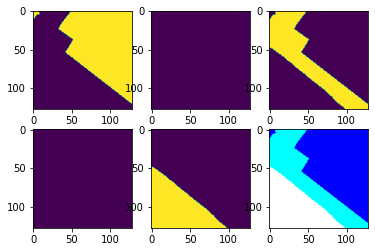

In [8]:
# Step 4
train_ref = one_hot_encoding(patches_train_ref)
valuation_ref = one_hot_encoding(patches_valuation_ref)

# exemplo
plt.figure()
f, axarr = plt.subplots(2,3) 
axarr[0,0].imshow(train_ref[1,:,:,0])
axarr[0,1].imshow(train_ref[1,:,:,1])
axarr[0,2].imshow(train_ref[1,:,:,2])
axarr[1,0].imshow(train_ref[1,:,:,3])
axarr[1,1].imshow(train_ref[1,:,:,4])
axarr[1,2].imshow(patches_train_ref[1])

# **Definir a rede  U-net**
Finalmente, após todas as etapas de pré-processamento, definimos a rede U-net. 
A arquitetura do modelo conta com blocos *encoder* para *downsampling* e um *decoder* para *upsampling*. Além disso, temos as *skip connections* que alimentam entradas mais posteriores da rede com saídas de outras camadas - e gera o formato de U característico da rede.

In [9]:
# Etapa 5 

# bloco de convolução 
def convolution_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder(input, num_filters):
    x = convolution_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = convolution_block(x, num_filters)
    return x

# define a rede
def unet(input_shape, n_classes):
  input_img = Input(input_shape)

  # downsample (enconder)
  s1, p1 = encoder(input_img, 64)
  s2, p2 = encoder(p1, 128)
  s3, p3 = encoder(p2, 256)
  s4, p4 = encoder(p3, 512)

  bottleneck = convolution_block(p4, 1024) # last enconder block 

  # upsample (decoder) 
  d1 = decoder(bottleneck, s4, 512)
  d2 = decoder(d1, s3, 256)
  d3 = decoder(d2, s2, 128)
  merged = decoder(d3, s1, 64) # last decoder block 

  output = Conv2D(n_classes,(1,1), activation = 'softmax')(merged)

  return Model(inputs = input_img, outputs = output, name='U-Net')


In [10]:
# inicializa a rede
adam = Adam(lr = 0.0001 , beta_1=0.9)
net = unet((patch_size, patch_size, channels), n_classes)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# **Treinando a rede**

Agora, treinamos a rede usando a função weighted_categorical_crossentropy como função de perda cujos pesos de cada classe *i* são definidos:

$ w_{i} = \frac{NumeroTotalPixels}{NumeroPixelsClasse_{i}}$

O cálculo do peso está demostrado abaixo. 

Além disso, adicionamos um *early stop* com paciência 10 na função de treinamento dada.

In [11]:
def compute_weights():
  # tr_ref_img is the original train image
  total_pixels  = tr_ref_img.shape[0]*tr_ref_img.shape[1]

  original_image_enconded = one_hot_encoding(tr_ref_img)

  # define weights: w_i = #total_pixels / #pixels_of_class_i 
  weights = [0 for i in range(n_classes)]
  for i in range(n_classes):
    pixels_of_class_i =   np.sum(original_image_enconded[:,:,i])
    weights[i] = pixels_of_class_i /total_pixels

  return weights

def weighted_categorical_crossentropy(weights):
        """
        A weighted version of keras.objectives.categorical_crossentropy
        
        Variables:
            weights: numpy array of shape (C,) where C is the number of classes
        
        Usage:
            weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
            loss = weighted_categorical_crossentropy(weights)
            model.compile(loss=loss,optimizer='adam')
        """
        weights = K.variable(weights)
        def loss(y_true, y_pred):
            # scale predictions so that the class probas of each sample sum to 1
            y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
            # clip to prevent NaN's and Inf's
            y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
            loss = y_true * K.log(y_pred) + (1-y_true) * K.log(1-y_pred)
            loss = loss * weights 
            loss = - K.mean(loss, -1)
            return loss
        return loss

def Train_model(net, patches_train, patches_tr_lb_h, patches_val, patches_val_lb_h, batch_size, epochs,learning_rate=0.0001):
  
  val_loss_list = [] # list of val losses for each epoch

  print('Start training.. ')

  for epoch in range(epochs):
    loss_tr = np.zeros((1 , 2))
    loss_val = np.zeros((1 , 2))
    n_batchs_tr = patches_train.shape[0]//batch_size
    patches_train , patches_tr_lb_h = shuffle(patches_train , patches_tr_lb_h , random_state = 0)
        
    # Training the network per batch
    for  batch in range(n_batchs_tr):
      x_train_b = patches_train[batch * batch_size : (batch + 1) * batch_size , : , : , :]
      y_train_h_b = patches_tr_lb_h[batch * batch_size : (batch + 1) * batch_size , :, :, :]
      loss_tr = loss_tr + net.train_on_batch(x_train_b , y_train_h_b)
    
    # Training loss
    loss_tr = loss_tr/n_batchs_tr
    print("%d [Training loss: %f , Train acc.: %.2f%%]" %(epoch , loss_tr[0 , 0], 100*loss_tr[0 , 1]))

    # Computing the number of batchs
    n_batchs_val = patches_val.shape[0]//batch_size

    # Evaluating the model in the validation set
    for  batch in range(n_batchs_val):
      x_val_b = patches_val[batch * batch_size : (batch + 1) * batch_size , : , : , :]
      y_val_h_b = patches_val_lb_h[batch * batch_size : (batch + 1) * batch_size , :, :, :]
      loss_val = loss_val + net.test_on_batch(x_val_b , y_val_h_b)
    
    # validation loss
    loss_val = loss_val/n_batchs_val
    print("%d [Validation loss: %f , Validation acc.: %.2f%%]" %(epoch , loss_val[0 , 0], 100*loss_val[0 , 1]))
    
    #################### Early stopping ####################
   
    val_loss_list.append(loss_val) # keep track of validation losses

    if epoch >= 9: #patience of 10 (star count on 0)

      last_ten = np.array(val_loss_list[-11:-1]) # last 10 val losses

      if np.sum( np.abs(last_ten-loss_val) ) < learning_rate*10:
        print("Early Stopping at epoch: ",epoch)
        return net

  return net


weights = compute_weights()
loss = weighted_categorical_crossentropy(weights)


In [12]:
# Etapa 6 e 7

net.summary()
net.compile(loss = loss, optimizer=adam , metrics=['accuracy'])
net = Train_model(net, patches_train.numpy(), train_ref,patches_valuation, valuation_ref, 5, 50)

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

## **Teste da Rede**
 
Finalmente, testamos a rede com um novo conjunto de dados e, por fim, reconstruimos a imagem final (que estava dividida em patches), comparando a referência com a previsão do modelo.

In [13]:
def Test(model, patch_test):
  result = model.predict(patch_test)
  predicted_class = np.argmax(result, axis=-1)
  return predicted_class

<Figure size 432x288 with 0 Axes>

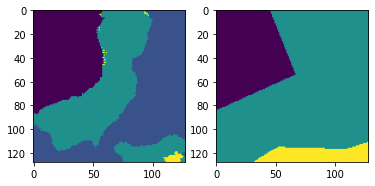

In [14]:
# Etapa 8
# cria os patches
patch_test, patch_test_ref = extract_patches(test_img, test_ref_img, patch_size, stride,skip_resize=True)

#salva as dimensões para reconstruir a imagem ao final
height = patch_test_ref.shape[1]
width = patch_test_ref.shape[2]

# aplica o reshape que foi pulado
patch_test = reshape_patches(patch_test,patch_size,channels)
patch_test_ref = reshape_patches(patch_test_ref,patch_size,channels)
 
# testa o modelo
predicted_labels = Test(net, patch_test)

test_ref =  one_hot_encoding(patch_test_ref)
test_ref = np.argmax(test_ref, axis=-1) 

#plot resultado de um patch
plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(predicted_labels[1])
axarr[1].imshow(test_ref[1])

A imagem completa:

<Figure size 432x288 with 0 Axes>

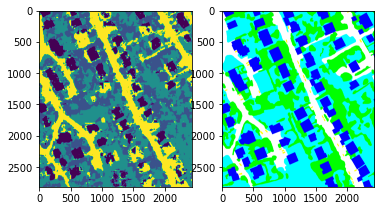

In [15]:
# Etapa 9

def rebuild_image(data,height,width):

  complete_image = []

  for h in range(height):

    row = [data[h*width+w] for w in range(width) ]

    complete_image.append(np.concatenate(row, axis=1))
    
  return np.array(np.concatenate(complete_image, axis=0))


#plot result
plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(rebuild_image(predicted_labels,height,width))
axarr[1].imshow(rebuild_image(patch_test_ref,height,width))

## **Métricas do Modelo**

Pro fim, utilizamos algumas métricas para qualificar e comparar os modelos utilizando diferentes tamanhos de patches (32x32, 64x64, 128x128). As métricas são calculadas para os dados de treino.

In [16]:
def compute_metrics(true_labels, predicted_labels):
  accuracy = 100*accuracy_score(true_labels, predicted_labels)
  f1score = 100*f1_score(true_labels, predicted_labels, average=None)
  recall = 100*recall_score(true_labels, predicted_labels, average=None)
  precision = 100*precision_score(true_labels, predicted_labels, average=None)
  return accuracy, f1score, recall, precision

In [17]:
accuracy, f1score, recall, precision = compute_metrics(test_ref.reshape(-1), predicted_labels.reshape(-1))

fig = go.Figure()
fig.add_traces(go.Scatter(x=[i for i in range(len(f1score))], y= f1score,name=f"f1score (avg:{round(f1score.mean())})"))
fig.add_traces(go.Scatter(x=[i for i in range(len(recall))], y= recall, name = f"recall (avg:{round(recall.mean())})"))
fig.add_traces(go.Scatter(x=[i for i in range(len(precision))], y= precision, name = f"precision (avg:{round(precision.mean())})"))
fig.update_layout(title=f"<b>Network Metrics | {patch_size}x{patch_size} </b> <br> Accuracy: {round(accuracy,3)}")
fig.show()

# *Comparação das Redes*

Por último, faremos a comparação da rede treinada com diferentes tamanhos de patches: 32x32, 64x64, 128x128.

A tabela abaixo resume os resultados obtidos para cada cada experimento:
<figure>
<center>
<img src= 'https://i.ibb.co/smxPpBj/resumo.png'/>
</figure>




**Acurácia e Perda**

As métricas de treino ficaram bastante próximas para os três experimentos. Considerando a validação, a rede com patches 32x32 perde para as demais com uma diferença um pouco maior. Finalmente, para os testes, apesar de ainda bastante próximos a rede com patches 128x128 é a melhor considerando *loss* e *accuary*.

Como dito, a diferença das métricas não é muito grande, o que é bastante interessante. Poderíamos imaginar que patches armazenariam mais informação ao longo da rede e, por isso, poderia ser muito mais eficiente, mas não é o caso. A rede consegue distinguir muito bem para todos as três configurações. 

**F1, Recall e Precisão**
Essas métricas também ficaram bastante próximas ( o que é coerente ), porém a alta precisão - comparada aos demais - da rede com patches 32x32 chama atenção. 

Para entender melhor, podemos plotar as métricas para os três experimentos (em que o eixo X é a classe):

<figure>
<center>
<img src= 'https://i.ibb.co/pJDHvLm/32.png' />
<img src= 'https://i.ibb.co/PwxfNZn/64.pngNX'/>
<img src= 'https://i.ibb.co/pwbGxdM/128.png'/>
</figure>

Podemos perceber claramente que todas as métricas possuem um valor **muito** baixo para a classe "4". A razão fica clara quando olhamos os pesos de cada uma das classes: 

1. 0.17626   
2. 0.33593
3. 0.25502
4. 0.00267
5. 0.23012

O peso da classe 4 é muito próximo de zero, assim a penalização por esse erro é muito baixa e os modelos acabam errando bastante. Se olharmos nossas imagens originais - e sabendo que o peso é definido pela contagem de pixels de cada classe sobre o numero total de pixels - fica claro que essa classe corresponde aos carros - ocupam uma área (e número de pixels muito menor que qualquer outra). 

Quando diminuimos o patche size (como é o caso 32x32) intuitivamente fica mais fácil de distinguir essa classe dos demais, já que a imagem total também é menor. 

**Resultados das imagens de teste**

1. Rede 32x32

<<a href="https://ibb.co/L1zDwT7"><img src="https://i.ibb.co/vkxC5Nn/32.png" alt="32" border="0"></a>


2. Rede 64x64

<a href="https://ibb.co/tBMV9ps"><img src="https://i.ibb.co/v1x0S4P/64.png" alt="64" border="0"></a>

3. Rede 128x 128

<a href="https://ibb.co/cY0Q3XC"><img src="https://i.ibb.co/Rjfcb4B/128.png" alt="128" border="0"></a>

Em que podemos perceber que a cada aumento do tamanho do patche melhor a qualidade (menos ruido) temos na previsão das classes. 